<a href="https://colab.research.google.com/github/arkincognito/PyTorch/blob/main/09_02_Pytorch_Weight_Init_BatchNorm_Dropout_Multicore_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Additional Components to enhance training

This notebook shows three additional components used to enhance training:
- Weight Initialization
- Dropout
- Batch Normalization

## Weight Initialization

There are two types of weight initialization
- RBM
- Xavier Initialization / He Initialization

RBM is a complex and uncommon these days, so I won't discuss about it any more.
Let's take a look at Xavier and He Initializations.

### Xavier Initialization
>#### Xavier Initialization with Normal Distribution
- Weight Initialization: $W \sim N(0, Var(W)$<br>
- Standard Deviation: $Var(W) = {\sqrt {1 \over n_{in} + n_{out}}}$

>#### Xavier Initialization with Uniform Distribution
- Weight Initialization: $W \sim U(-\sqrt{6\over n_{in} + n_{out}}, \sqrt{6\over n_{in} + n_{out}})$

### He Initialization
>#### He Initialization with Normal Distribution
- Weight Initialization: $W \sim N(0, Var(W)$<br>
- Standard Deviation: $Var(W) = {\sqrt {1 \over n_{in}}}$

>#### He Initialization with Uniform Distribution
- Weight Initialization: $W \sim U(-\sqrt{6\over n_{in}}, \sqrt{6\over n_{in}})$

### Pytorch Code
Pytorch code example for Xavier Uniform Distribution Initialization:<br>
```
linear1 = nn.Linear(256, 256, bias=True)
nn.init.xavier_uniform_(linear1.weight)
```

## Dropout

Dropout applies redundancy to the model and prevent overfitting.

Other methods used to reduce overfitting include:
- More Training data
- Less Feature
- Regularization




### Pytorch Code
Pytorch code example for Dropout:<br>
```
linear1 = nn.Linear(784, 256, bias=True)
linear2 = nn.Linear(256, 256, bias=True)
linear3 = nn.Linear(256, 256, bias=True)
linear4 = nn.Linear(256, 10, bias=True)
relu = nn.ReLU()
dropout = nn.Dropout(p=drop_prob) #0<p<1

model = nn.Sequential(linear1, relu, dropout,
                      linear2, relu, dropout,
                      linear3, relu, dropout,
                      linear4).to(device)
```
Since the model behavior changes between training and evaluating, we set the model status by `.train()` and `.eval()`
```
model.train() #dropout = True
for epoch in range(training_epoch):
...

...

with torch.no_grad():
  model.eval() #dropout = False
  ...
```

## Batch Normalization
Methods used to prevent Gradient Vanishing and Gradient Exploding:
- Change Activation Function - other than Sigmoid
- Careful initialiation
- Small Learning Rate - SLOW Training

Batch Normalization can solve the Gradient problems by reducing internal covariant shift.<br>
Inputs on each layer will stay in an anticipated range.



### Algorithm
>**Input:** Values of x over a mini-batch: $\\B = \{x_1..._m\}$<br>
**Parameters to be learned in BN:** $\gamma, \beta$<br>
**Output:** $\{y_i = BN_{\gamma,\beta}(x_i)\}$<br>

>**Mini-Batch Mean:** $$\mu_B \leftarrow \displaystyle\sum_{i=1}^{m} x_i$$
>**Mini-Batch Variance:** $$\sigma^2_B \leftarrow \displaystyle\sum_{i=1}^{m} (x_i - \mu_B)^2$$
>**Normalize:** $$\hat x_i \leftarrow {x_i - \mu_B \over \sqrt\sigma^2_B + \epsilon}$$
>**Scale and Shift:** $$y_i \leftarrow \gamma \hat x_i + \beta 	\equiv BN_{\gamma,\beta}(x_i)$$


### Pytorch Code

Pytorch code example for Batch Normalization:<br>
```
linear1 = nn.Linear(784, 256, bias=True)
linear2 = nn.Linear(256, 256, bias=True)
linear3 = nn.Linear(256, 10, bias=True)
relu = nn.ReLU()
bn1 = nn.BatchNorm1d(256)
bn2 = nn.BatchNorm1d(256)

model = nn.Sequential(linear1, bn1, relu,
                      linear2, bn2, relu, 
                      linear3).to(device)
```
Since the model behavior changes between training and evaluating, we set the model status by `.train()` and `.eval()`

```
model.train() #dropout = True
for epoch in range(training_epoch):
...

...

with torch.no_grad():
  model.eval() #dropout = False
  ...
```

# Let's Code them

Enough with the theories.<br>
Let's start coding!<br>

First, we'll see the training loss behavior of vanilla MLPs.<br>
To see how the width of net affects the training process, we'll build 4 2-Layer MLPs with net width of 32, 64, 128, 256.<br>
We'll choose the best net out of these four and set it as the base net.

Then, we'll add **Weight Initialization** and **Batch Normalization** to the best net, as well as **Dropout** with different **Dropout Ratios** and see which component adds benefit to the model

## PyTorch/XLA preparation

As in [previous notebook]('https://colab.research.google.com/drive/1pBl22EzBXbaIBrO-lr8nkxnPGfCm-OLY#scrollTo=ej0qnTFC-p6m'), prepare Pytorch/XLA for Multi-Core TPU.


In [ ]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
# Installs PyTorch, PyTorch/XLA, and Torchvision
# Copy this cell into your own notebooks to use PyTorch on Cloud TPUs 
# Warning: this may take a couple minutes to run
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 133.6MB 49kB/s 
     |████████████████████████████████| 61kB 3.9MB/s 
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12


In [ ]:
import torch
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torchvision
from torchvision import datasets
import torch.nn as nn
import torchvision.transforms as transforms
import torch_xla.distributed.parallel_loader as pl
import time

## Model Classes

Here, we'll define various model classes.<br>
All nets take `FLAGS['net_width']`.<br>

- BaseNet: 3 linear layers with ReLU activation
- NN_DO: BaseNet with Dropout. Takes `FLAGS['drop_rate']`
- NN_xavier_uniform: BaseNet with Xavier Uniform Weight Initialization
- NN_xavier_normal: BaseNet with Xavier Uniform Weight Initialization
- BN: BaseNet with Batch Normalization

In [ ]:
#Define Networks with the aspects we've discussed above.
## Base Network of 3 linear layers and ReLU activation
class BaseNet(nn.Module):
  def __init__(self):
    super(BaseNet, self).__init__()
    self.linear1 = nn.Linear(784, FLAGS['net_width'], bias=True)
    self.linear2 = nn.Linear(FLAGS['net_width'], FLAGS['net_width'], bias=True)
    self.linear3 = nn.Linear(FLAGS['net_width'], 10, bias=True)

    self.layer1 = nn.Sequential(
        self.linear1,    
        nn.ReLU(),
    )
    self.layer2 = nn.Sequential(
        self.linear2,
        nn.ReLU(),
        self.linear3
    )
  def forward(self, x):
    pred = self.layer1(x)
    pred = self.layer2(pred)
    return pred

## Net with Dropout
class NN_DO(nn.Module):
  def __init__(self):
    super(NN_DO, self).__init__()
    self.linear1 = nn.Linear(784, FLAGS['net_width'], bias=True)
    self.linear2 = nn.Linear(FLAGS['net_width'], FLAGS['net_width'], bias=True)
    self.linear3 = nn.Linear(FLAGS['net_width'], 10, bias=True)

    self.layer1 = nn.Sequential(
        self.linear1,    
        nn.ReLU(),
        nn.Dropout(p=FLAGS['drop_rate'])
    )
    self.layer2 = nn.Sequential(
        self.linear2,
        nn.ReLU(),
        nn.Dropout(p=FLAGS['drop_rate']),
        self.linear3
    )
  def forward(self, x):
    pred = self.layer1(x)
    pred = self.layer2(pred)
    return pred

## Net with Xavier Uniform Initialization
class NN_xavier_uniform(nn.Module):
  def __init__(self):
    super(NN_xavier_uniform, self).__init__()
    self.linear1 = nn.Linear(784, FLAGS['net_width'], bias=True)
    self.linear2 = nn.Linear(FLAGS['net_width'], FLAGS['net_width'], bias=True)
    self.linear3 = nn.Linear(FLAGS['net_width'], 10, bias=True)

    nn.init.xavier_uniform_(self.linear1.weight)
    nn.init.xavier_uniform_(self.linear2.weight)
    nn.init.xavier_uniform_(self.linear3.weight)

    self.layer1 = nn.Sequential(
        self.linear1,    
        nn.ReLU(),
    )
    self.layer2 = nn.Sequential(
        self.linear2,
        nn.ReLU(),
        self.linear3
    )
  def forward(self, x):
    pred = self.layer1(x)
    pred = self.layer2(pred)
    return pred

## Net with Xavier Normal Initialization
class NN_xavier_normal(nn.Module):
  def __init__(self):
    super(NN_xavier_normal, self).__init__()
    self.linear1 = nn.Linear(784, FLAGS['net_width'], bias=True)
    self.linear2 = nn.Linear(FLAGS['net_width'], FLAGS['net_width'], bias=True)
    self.linear3 = nn.Linear(FLAGS['net_width'], 10, bias=True)

    nn.init.xavier_normal_(self.linear1.weight)
    nn.init.xavier_normal_(self.linear2.weight)
    nn.init.xavier_normal_(self.linear3.weight)

    self.layer1 = nn.Sequential(
        self.linear1,    
        nn.ReLU(),
    )
    self.layer2 = nn.Sequential(
        self.linear2,
        nn.ReLU(),
        self.linear3
    )
  def forward(self, x):
    pred = self.layer1(x)
    pred = self.layer2(pred)
    return pred

## Net with Batch Normalization
class BN(nn.Module):
  def __init__(self):
    super(BN, self).__init__()
    self.linear1 = nn.Linear(784, FLAGS['net_width'], bias=True)
    self.linear2 = nn.Linear(FLAGS['net_width'], FLAGS['net_width'], bias=True)
    self.linear3 = nn.Linear(FLAGS['net_width'], 10, bias=True)

    self.layer1 = nn.Sequential(
        self.linear1,
        nn.BatchNorm1d(FLAGS['net_width']),
        nn.ReLU(),
    )
    self.layer2 = nn.Sequential(
        self.linear2,
        nn.BatchNorm1d(FLAGS['net_width']),
        nn.ReLU(),
        self.linear3
    )
    
  def forward(self, x):
    pred = self.layer1(x)
    pred = self.layer2(pred)
    return pred

## Trainer

We'll define TPU multicore trainer.<br>
This trainer will return `training_history` and `validation_history`, as well as the `data`, `target`, and `pred`iction of the last batch of data.<br>
We'll use training history and validation history to visualize training progress and see when **Overfitting** happens.
Data, Target, and Prediction of the last batch will be used to visualize the prediction of the model.

In [ ]:
def train_model(net):
  ### Setup 
  ### Dataloader construction
  # Downloads train and test datasets
  # Note: master goes first and downloads the dataset only once(xm.rendezvous).
  # All the other workers wait for the master to be done downloading.

  if not xm.is_master_ordinal():
    xm.rendezvous('download_only_once')

  train_dataset = datasets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

  test_dataset = datasets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)
  
  if xm.is_master_ordinal():
    xm.rendezvous('download_only_once')

  # Creates the (distributed) train sampler which let this process only access
  # its portion of the training dataset.
  train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=True)
  
  # Creates dataloaders, which load data in batches
  # Note: test loader is not shuffled, nor sampled
  # and does not drop the last remaining data.
  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=FLAGS['batch_size'],
      sampler=train_sampler,
      num_workers=FLAGS['num_workers'],
      drop_last=True)

  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=FLAGS['batch_size'],
      shuffle=False,
      num_workers=FLAGS['num_workers'],
      drop_last=False)
  
  ### Optimizer, and loss function creation
  # Acquires the (unique) Cloud TPU core corresponding to this process's index
  device = xm.xla_device()
  # Get model, loss function, and optimizer
  model = net.to(device)   
  loss_fn = torch.nn.CrossEntropyLoss()
  # Scale learning rate to world size
  lr = FLAGS['learning_rate'] * xm.xrt_world_size()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  def train_loop_fn(loader):
    model.train()
    # drop_last=True for training loader
    # loss_fn returns avg loss of the batch
    # avg_training_loss_over_whole_training_set
    # = sum(loss at each batch) / total_batch_num
    batch_num_total = len(loader)
    training_loss = 0
    for batch_num, (data, targets) in enumerate(loader):
      output = model(data.view(-1,28*28))
      loss = loss_fn(output, targets)
      optimizer.zero_grad()
      loss.backward()
      xm.optimizer_step(optimizer)
      training_loss += loss / batch_num_total
    return training_loss
        
  def test_loop_fn(loader):
    # drop_last=False for testing loader
    # loss_fn returns avg loss of the batch
    # avg_validating_loss_over_whole_validation_set
    # = sum(avg loss at each batch * size_of_each_batch) / total_samples
    total_samples = 0
    num_correct = 0
    validation_loss = 0
    model.eval()
    for data, targets in loader:
      output = model(data.view(-1,28*28))
      loss = loss_fn(output, targets)
      validation_loss += loss * data.size()[0]
      pred = output.max(1, keepdim=True)[1]
      num_correct += pred.eq(targets.view_as(pred)).sum().item()
      total_samples += data.size()[0]

    accuracy = 100.0 * num_correct / total_samples
    validation_loss = validation_loss / total_samples
    return accuracy, validation_loss, data, pred, targets

  # Train and eval loops
  accuracy = 0.0
  training_history = []
  evaluating_history = []
  for epoch in range(1, FLAGS['num_epochs'] + 1):
    para_loader = pl.ParallelLoader(train_loader, [device])
    training_loss = train_loop_fn(para_loader.per_device_loader(device))

    para_loader = pl.ParallelLoader(test_loader, [device])
    accuracy, validation_loss, data, pred, targets  = test_loop_fn(para_loader.per_device_loader(device))
    training_history.append(training_loss.tolist())
    evaluating_history.append(validation_loss.tolist())
    if FLAGS['metrics_debug']:
      xm.master_print(met.metrics_report(), flush=True)
  return training_history, evaluating_history, data, pred, targets

## Plot Helpers
First, import files to build plot helpers and set the font color and font size.

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.unicode_minus'] = False
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import seaborn as sns
%matplotlib inline
SMALL_SIZE = 10
MEDIUM_SIZE = 15
LARGE_SIZE = 18

plt.rc('font', size=SMALL_SIZE) # Default text sizes
plt.rc('axes', titlesize=LARGE_SIZE) # Axes title fontsize
plt.rc('axes', labelsize=MEDIUM_SIZE) # x and y labels' fontsize
plt.rc('xtick', labelsize=SMALL_SIZE) # x tick label size
plt.rc('ytick', labelsize=SMALL_SIZE) # y tick label size
plt.rc('legend', fontsize=SMALL_SIZE) # Legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE) # Figure title size

COLOR = 'white'
mpl.rcParams['text.color'] = 'black' # Default text color(including legend)
mpl.rcParams['axes.labelcolor'] = COLOR # Axes label color
mpl.rcParams['axes.titlecolor'] = COLOR # Subplot Title Color
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

## Prediction Visualization Helper

In [ ]:
# Result Visualization Helper
import math

M, N = 4, 6
RESULT_IMG_PATH = '/tmp/test_result.png'

def plot_results(images, labels, preds):
  images, labels, preds = images[:M*N], labels[:M*N], preds[:M*N]
  inv_norm = transforms.Normalize((-0.1307/0.3081,), (1/0.3081,))

  num_images = images.shape[0]
  fig, axes = plt.subplots(M, N, figsize=(11, 9))
  fig.suptitle('Correct / Predicted Labels (Red text for incorrect ones)')

  for i, ax in enumerate(fig.axes):
    ax.axis('off')
    if i >= num_images:
      continue
    img, label, prediction = images[i], labels[i], preds[i]
    img = inv_norm(img)
    img = img.squeeze() # [1,Y,X] -> [Y,X]
    label, prediction = label.item(), prediction.item()
    if label == prediction:
      ax.set_title(prediction, color='blue', fontsize=22)
    else:
      ax.set_title(
          'X {}/{}'.format(label, prediction), color='red')
    ax.imshow(img)
  plt.savefig(RESULT_IMG_PATH, transparent=True)

### Training History Visualization Helper

In [ ]:
import pandas as pd

def graph_history(TH_PATH, EH_PATH, net_names, ylim=(0,0.3), show_move_avg=True):  
  training_histories = pd.read_csv(TH_PATH, sep=',')
  evaluation_histories = pd.read_csv(EH_PATH, sep=',')
  fig = plt.figure(figsize=(15,8))
  tl_plot = sns.lineplot(data=training_histories[net_names], dashes=[(2, 2) for _ in net_names], linewidth=2)
  el_plot = sns.lineplot(data=evaluation_histories[net_names], dashes=False, linewidth=2)
  tl_plot.set(ylim=ylim)
  el_plot.set(ylim=ylim)
  if show_move_avg:
    moving_average_cols = []
    for net_name in net_names:
      evaluation_histories[net_name + '_moving_average'] = evaluation_histories[net_name].rolling(5).mean().shift(-2)
      moving_average_cols.append(net_name + '_moving_average')
    el_average_plot = sns.lineplot(data=evaluation_histories[moving_average_cols], dashes=[(5, 2) for _ in moving_average_cols], linewidth=2)
    el_average_plot.set(ylim=ylim)
  plt.show()

### Training Process
Training histories will be saved into csv files

In [ ]:
# Start training processes
def _mp_fn(rank, flags, NETS, NET_NAMES):
  global FLAGS
  FLAGS = flags
  torch.set_default_tensor_type('torch.FloatTensor')
  # Sets a common random seed
  torch.manual_seed(FLAGS['seed'])
  training_histories = {}
  evaluation_histories = {}
  
  for net, net_name in zip(NETS, NET_NAMES):
    start_time = time.time()
    training_history, evaluating_history, data, pred, targets = train_model(net)
    training_histories[net_name] = training_history
    evaluation_histories[net_name] = evaluating_history
    if rank == 0:
      print(net_name, ' Training complete. Training Time: ', time.time() - start_time)
  if rank == 0:
    training_histories = pd.DataFrame(training_histories)
    evaluation_histories = pd.DataFrame(evaluation_histories)
    
    training_histories.to_csv(TH_PATH, sep=',', float_format = '%.6f')
    evaluation_histories.to_csv(EH_PATH, sep=',', float_format = '%.6f')

    # Retrieve tensors that are on TPU core 0 and plot.
    plot_results(data.cpu(), pred.cpu(), targets.cpu())

## BaseNet Comparison

Run base nets with `net_width` of 32, 64, 128, and 256 to see the effect of net width.

In [ ]:
# Configures training (and evaluation) parameters
FLAGS = {}
FLAGS['num_workers'] = 8
FLAGS['batch_size'] = 32
FLAGS['num_epochs'] = 25
FLAGS['seed'] = 0
FLAGS['learning_rate'] = 0.000125
FLAGS['num_cores'] = 8
FLAGS['metrics_debug'] = False
FLAGS['drop_rate'] = 0

FLAGS['net_width'] = 32
smallest_net = BaseNet()
FLAGS['net_width'] = 64
small_net = BaseNet()
FLAGS['net_width'] = 128
middle_net = BaseNet()
FLAGS['net_width'] = 256
large_net = BaseNet()

BASE_NETS = [smallest_net, small_net, middle_net, large_net]
BASE_NET_NAMES = ['32_Net', '64_Net', '128_Net', '256_Net']

TH_PATH = '/tmp/training_histories.csv'
EH_PATH = '/tmp/evaluation_histories.csv'

xmp.spawn(_mp_fn, args=(FLAGS, BASE_NETS, BASE_NET_NAMES), nprocs=FLAGS['num_cores'], start_method='fork')

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw




Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
32_Net  Training complete. Training Time:  176.5495228767395
64_Net  Training complete. Training Time:  172.38025093078613
128_Net  Training complete. Training Time:  172.2764937877655
256_Net  Training complete. Training Time:  172.74540948867798


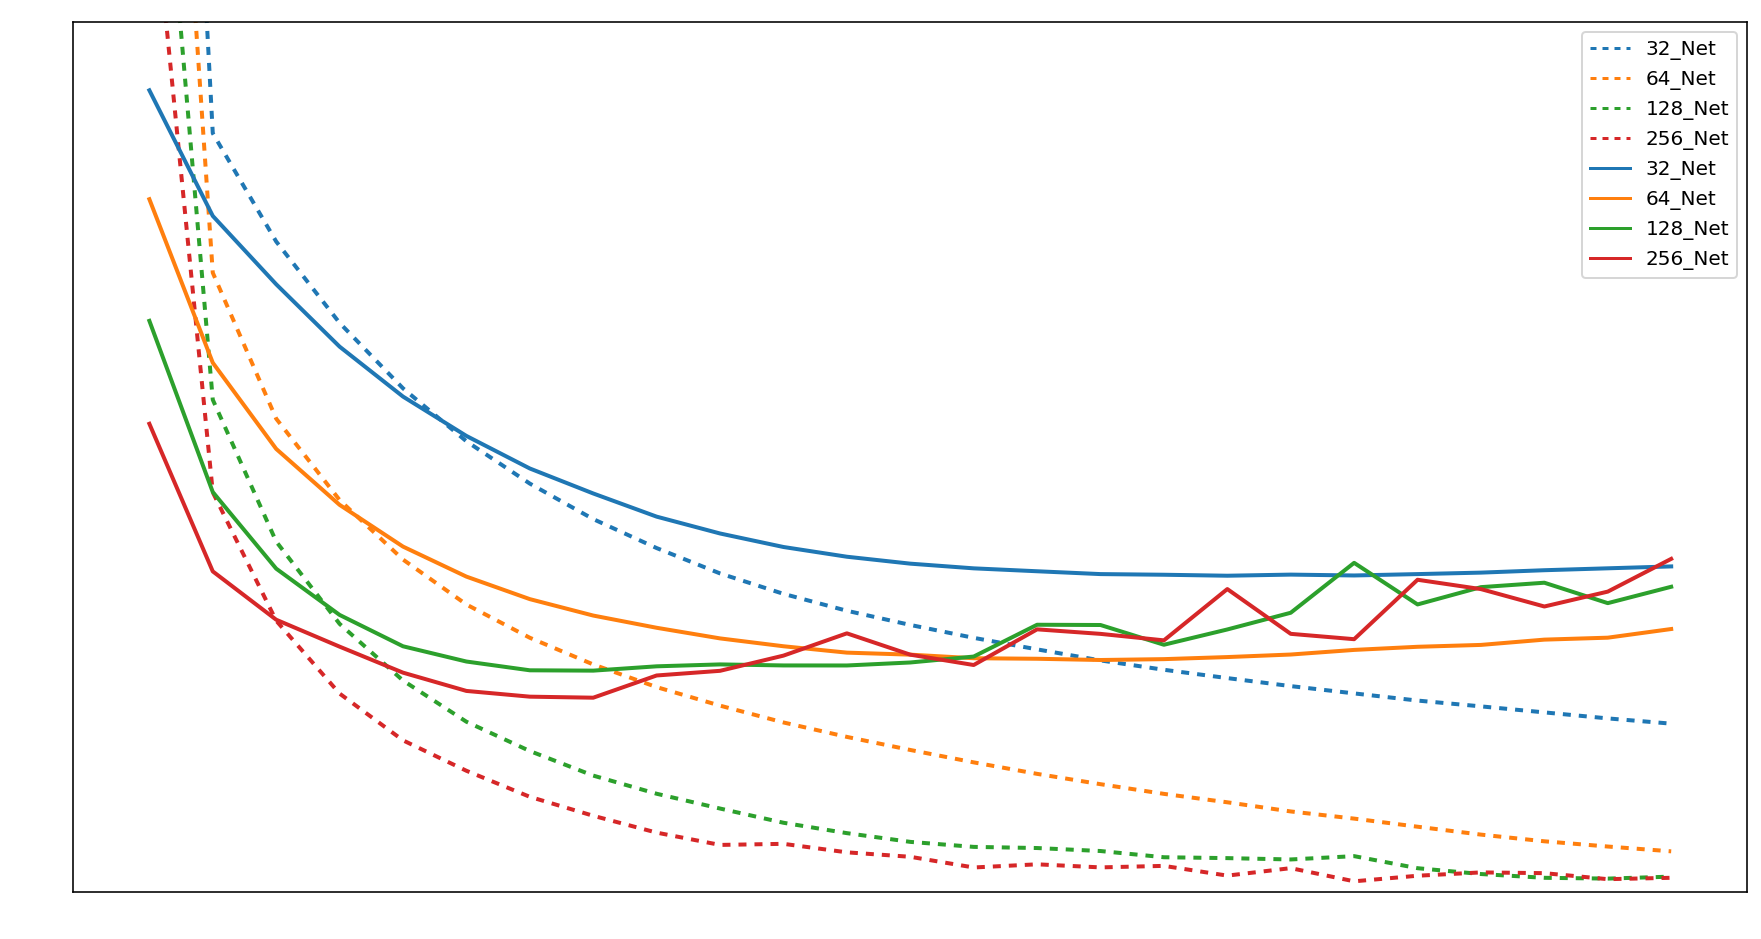

In [ ]:
graph_history(TH_PATH, EH_PATH, BASE_NET_NAMES, ylim=(0,0.35), show_move_avg=False)

Legends
>Training Loss: Dashed Lines<br>
>Validation Loss: Solid Lines<br>

We can see that the wider the net, the better performance in both training loss and validation loss.<br>
However, wider nets tend to have fast increase of validation loss after hitting the minimum even though their training losses are significantly smaller than  `32_net`.<br>
This shows ***'More the Features, Faster the Overfitting'***.

## Weight Initialization and Batch Normalization
let's compare the basenet with the xavier weight initialized versions and batch normalized version.

In [ ]:
# Configure net parameters and build nets.

FLAGS['net_width'] = 256
basenet = BaseNet()
nn_xu = NN_xavier_uniform()
nn_xn = NN_xavier_normal()
bn = BN()

WIBN_NETS = [basenet, nn_xu, nn_xn, bn]
WIBN_NET_NAMES = ['Base', 'Xavier_Uniform', 'Xavier_Normal', 'Batch_Normalization']

In [ ]:
TH_PATH = '/tmp/training_histories_wibn.csv'
EH_PATH = '/tmp/evaluation_histories_wibn.csv'
FLAGS['num_epochs'] = 25
xmp.spawn(_mp_fn, args=(FLAGS,WIBN_NETS,WIBN_NET_NAMES), nprocs=FLAGS['num_cores'], start_method='fork')

Base  Training complete. Training Time:  176.05702662467957
Xavier_Uniform  Training complete. Training Time:  172.72961282730103
Xavier_Normal  Training complete. Training Time:  171.93620657920837
Batch_Normalization  Training complete. Training Time:  184.42202401161194


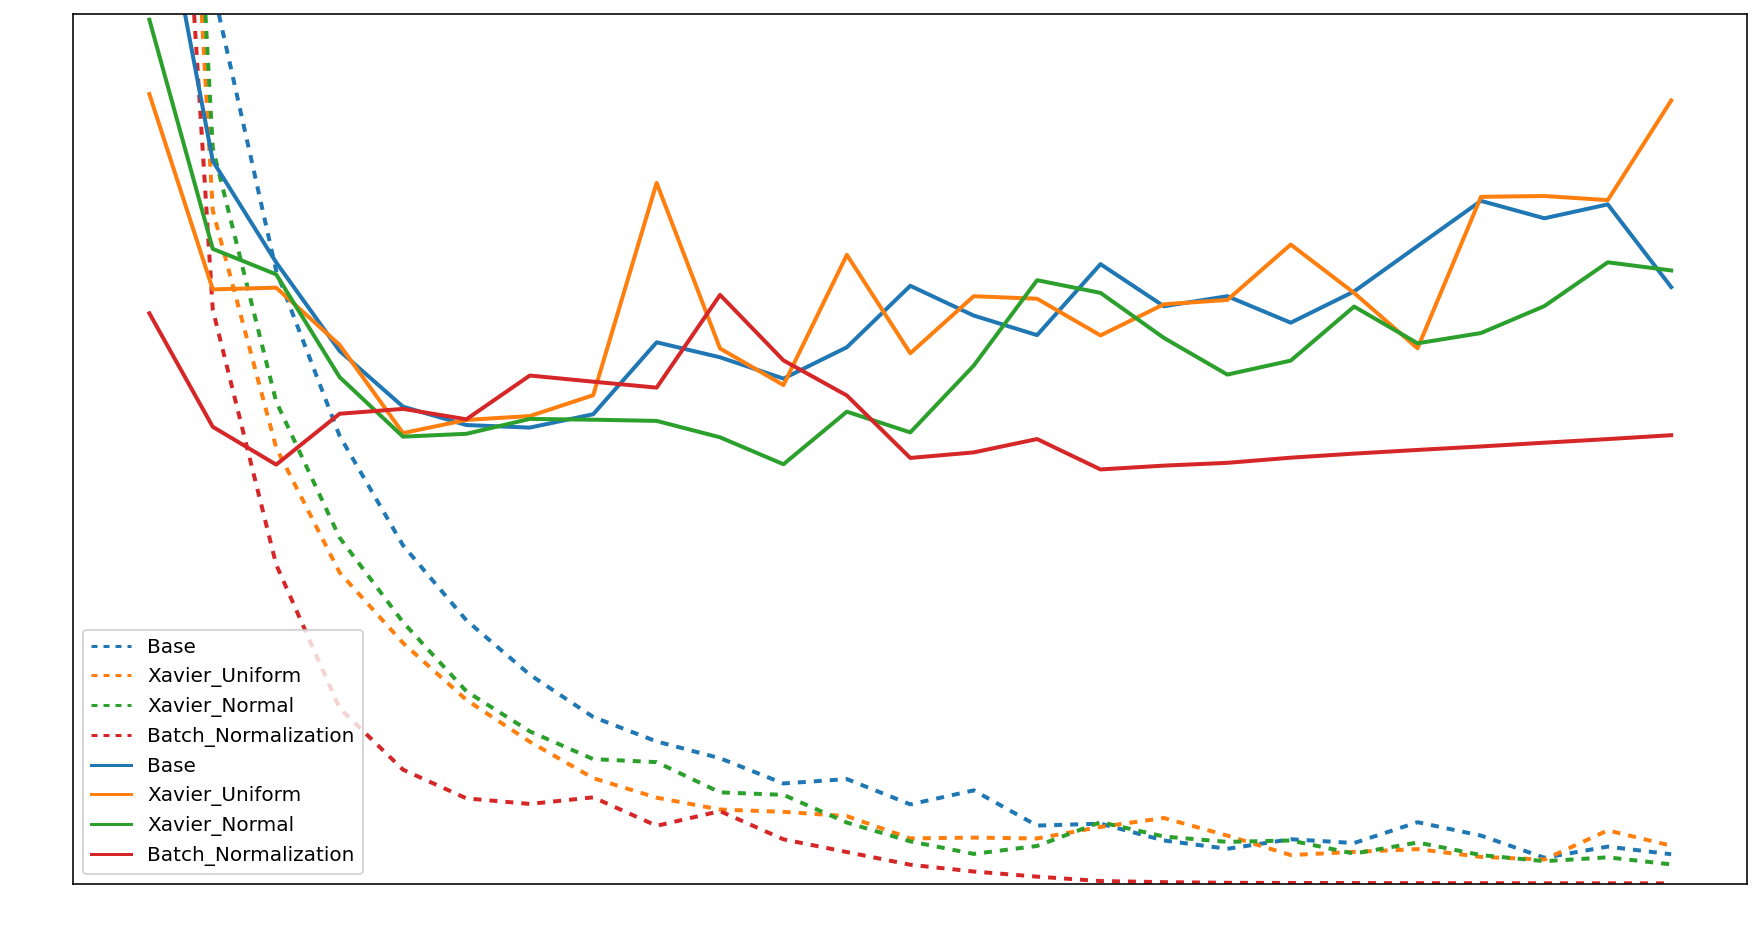

In [ ]:
graph_history(TH_PATH, EH_PATH, WIBN_NET_NAMES, ylim=(0,0.15), show_move_avg=False)

Legends
>Training Loss: Dashed Lines<br>
>Valiation Loss: Solid Lines<br>

##Evaluating each components

#### Overfitting
First off, we can see that **Overfit** occurs as the training continues. <br>
Validation loss increases while training loss continues to decrease after **4~6 epochs**.<br>
As the training continues, model picks up the training-data-specific features and **Overfit** to the training data.<br>
**Batch Normalization** shows lower training loss and validation loss than the base net throughout the training.<br>
**Dropout** also shows lower training loss and validation loss than the base net.


To reduce **Overfitting**, we may:
* Stop the training when validation loss starts to increase.
* Apply Batch Normalization and/or Dropout


### Weight Initialization

We can see that by simply applying *smart* weight initialization, training and validation loss can be reduced.

## Dropout
Let's see how dropout affects the net's performance.<br>
We'll compare basenet and nets with `drop_rate` of 0.1, 0.25, 0.5, 0.75 and 0.9 to find the optimal `drop_rate`.

In [ ]:
# Configure net parameters and build nets.
basenet = BaseNet()
FLAGS['drop_rate'] = 0.1
nn_do01 = NN_DO()
FLAGS['drop_rate'] = 0.25
nn_do25 = NN_DO()
FLAGS['drop_rate'] = 0.5
nn_do50 = NN_DO()
FLAGS['drop_rate'] = 0.75
nn_do75 = NN_DO()
FLAGS['drop_rate'] = 0.9
nn_do90 = NN_DO()

DO_NETS = [basenet, nn_do01, nn_do25, nn_do50, nn_do75, nn_do90]
DO_NET_NAMES = ['Base', 'DR_0.1', 'DR_0.25', 'DR_0.5', 'DR_0.75', 'DR_0.9']

TH_PATH = '/tmp/training_histories_do.csv'
EH_PATH = '/tmp/evaluation_histories_do.csv'
FLAGS['num_epochs'] = 25
xmp.spawn(_mp_fn, args=(FLAGS,DO_NETS,DO_NET_NAMES,), nprocs=FLAGS['num_cores'], start_method='fork')

Base  Training complete. Training Time:  184.66762399673462
DR_0.1  Training complete. Training Time:  187.9400384426117
DR_0.25  Training complete. Training Time:  186.04964804649353
DR_0.5  Training complete. Training Time:  186.27432942390442
DR_0.75  Training complete. Training Time:  186.7361400127411
DR_0.9  Training complete. Training Time:  188.33413815498352


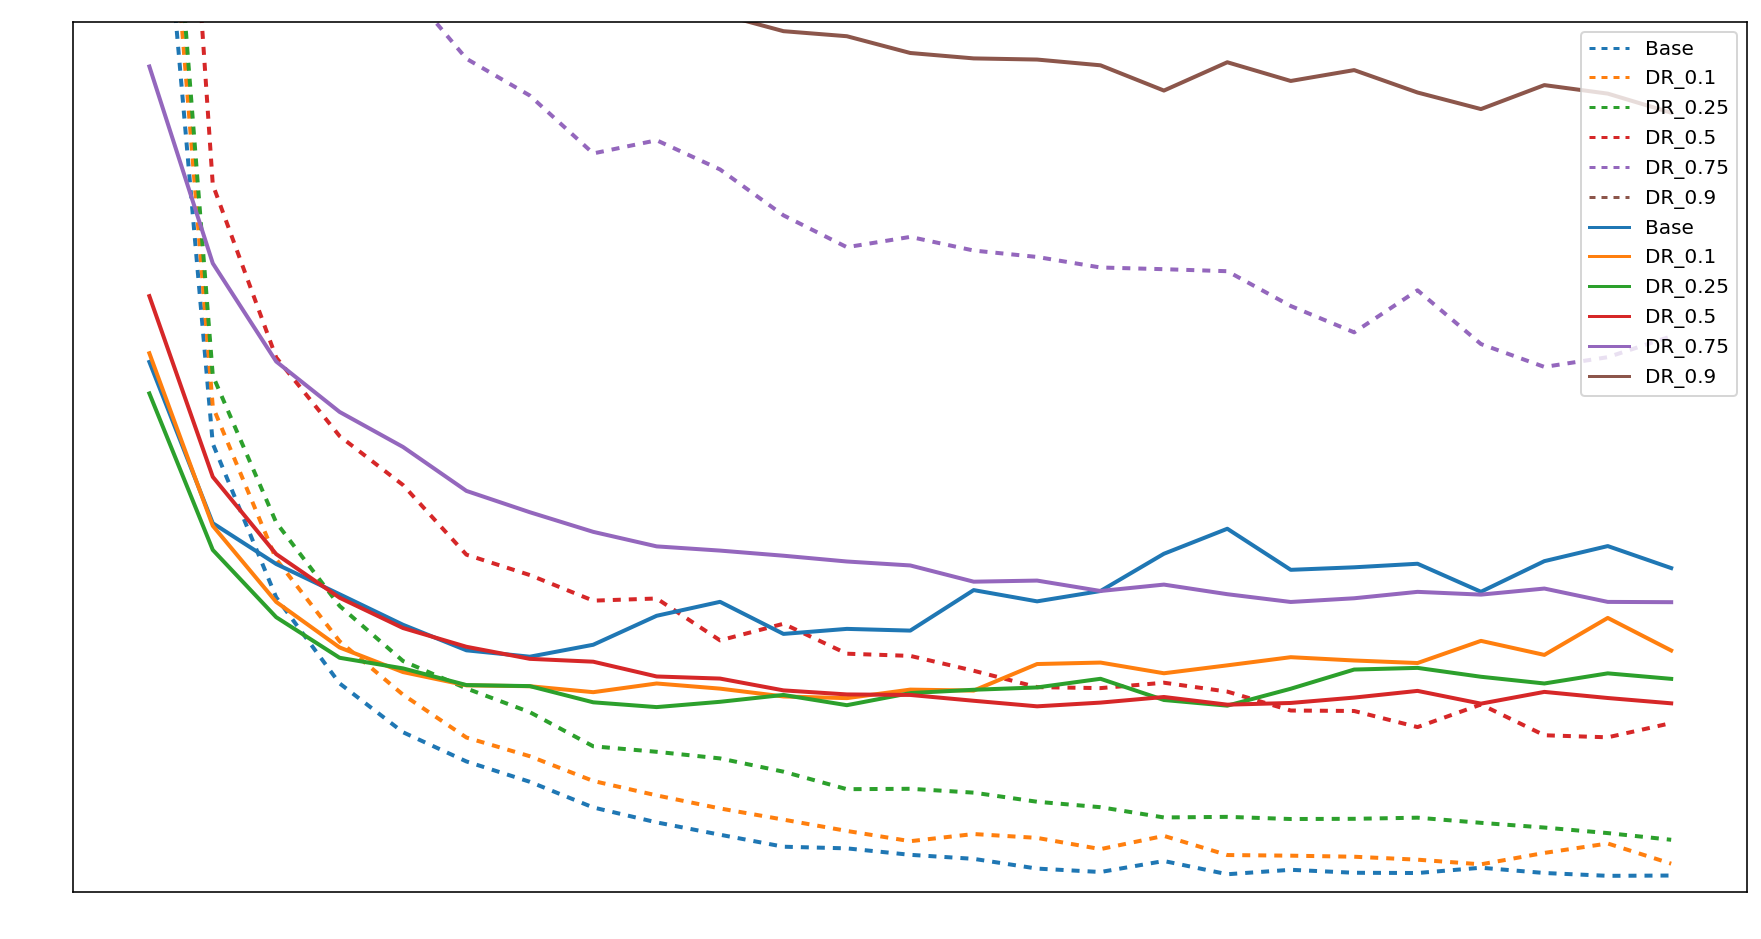

In [ ]:
graph_history(TH_PATH, EH_PATH, DO_NET_NAMES, ylim=(0,0.3), show_move_avg=False)

Legends
>Training Loss: Dashed Lines<br>
>Valiation Loss: Solid Lines<br>

Every net with **Dropout** feature shows larger **training loss** than the base net.<Br>
However, nets with `drop_rate` of 0.1, 0.25, and 0.5 show smaller **validation loss**.<br>
Also, 0.25 and 0.5 `drop_rate` nets show less **overfitting**.<br>

## Final Net
For the final test, we'll build a net with 256 `net_width`, `xavier_uniform`, 25% `drop_rate`, and `BatchNorm1d`.

In [ ]:
class Final_Net(nn.Module):
  def __init__(self):
    super(Final_Net, self).__init__()
    self.linear1 = nn.Linear(784, FLAGS['net_width'], bias=True)
    self.linear2 = nn.Linear(FLAGS['net_width'], FLAGS['net_width'], bias=True)
    self.linear3 = nn.Linear(FLAGS['net_width'], 10, bias=True)

    nn.init.xavier_uniform_(self.linear1.weight)
    nn.init.xavier_uniform_(self.linear2.weight)
    nn.init.xavier_uniform_(self.linear3.weight)

    self.layer1 = nn.Sequential(
        self.linear1,
        nn.BatchNorm1d(FLAGS['net_width']),
        nn.ReLU(),
        nn.Dropout(p=FLAGS['drop_rate'])
    )
    self.layer2 = nn.Sequential(
        self.linear2,
        nn.BatchNorm1d(FLAGS['net_width']),
        nn.ReLU(),
        nn.Dropout(p=FLAGS['drop_rate']),
        self.linear3
    )
    
  def forward(self, x):
    pred = self.layer1(x)
    pred = self.layer2(pred)
    return pred

In [ ]:
FLAGS['drop_rate'] = 0.25
FLAGS['net_width'] = 256

final_net = Final_Net()
FINAL_NETS = [final_net]
FINAL_NET_NAMES = ['Final_Net']

TH_PATH = '/tmp/training_histories_final.csv'
EH_PATH = '/tmp/evaluation_histories_final.csv'
FLAGS['num_epochs'] = 25

xmp.spawn(_mp_fn, args=(FLAGS,FINAL_NETS,FINAL_NET_NAMES,), nprocs=FLAGS['num_cores'], start_method='fork')

Final_Net  Training complete. Training Time:  202.04333591461182


### Data merge

In [ ]:
final_th = pd.read_csv('/tmp/training_histories_final.csv')
final_eh = pd.read_csv('/tmp/evaluation_histories_final.csv')

final_th = final_th.merge(pd.read_csv('/tmp/training_histories_wibn.csv'))
final_eh = final_eh.merge(pd.read_csv('/tmp/evaluation_histories_wibn.csv'))

final_th = final_th.merge(pd.read_csv('/tmp/training_histories_do.csv')[['Unnamed: 0', 'DR_0.1', 'DR_0.25', 'DR_0.5']])
final_eh = final_eh.merge(pd.read_csv('/tmp/evaluation_histories_do.csv')[['Unnamed: 0', 'DR_0.1', 'DR_0.25', 'DR_0.5']])

TH_PATH = '/tmp/training_histories_fin.csv'
EH_PATH = '/tmp/evaluation_histories_fin.csv'

final_th.drop(columns=['Unnamed: 0'], inplace=True)
final_eh.drop(columns=['Unnamed: 0'], inplace=True)

final_th.to_csv(TH_PATH, sep=',', float_format = '%.6f')
final_eh.to_csv(EH_PATH, sep=',', float_format = '%.6f')

### Final Visualization

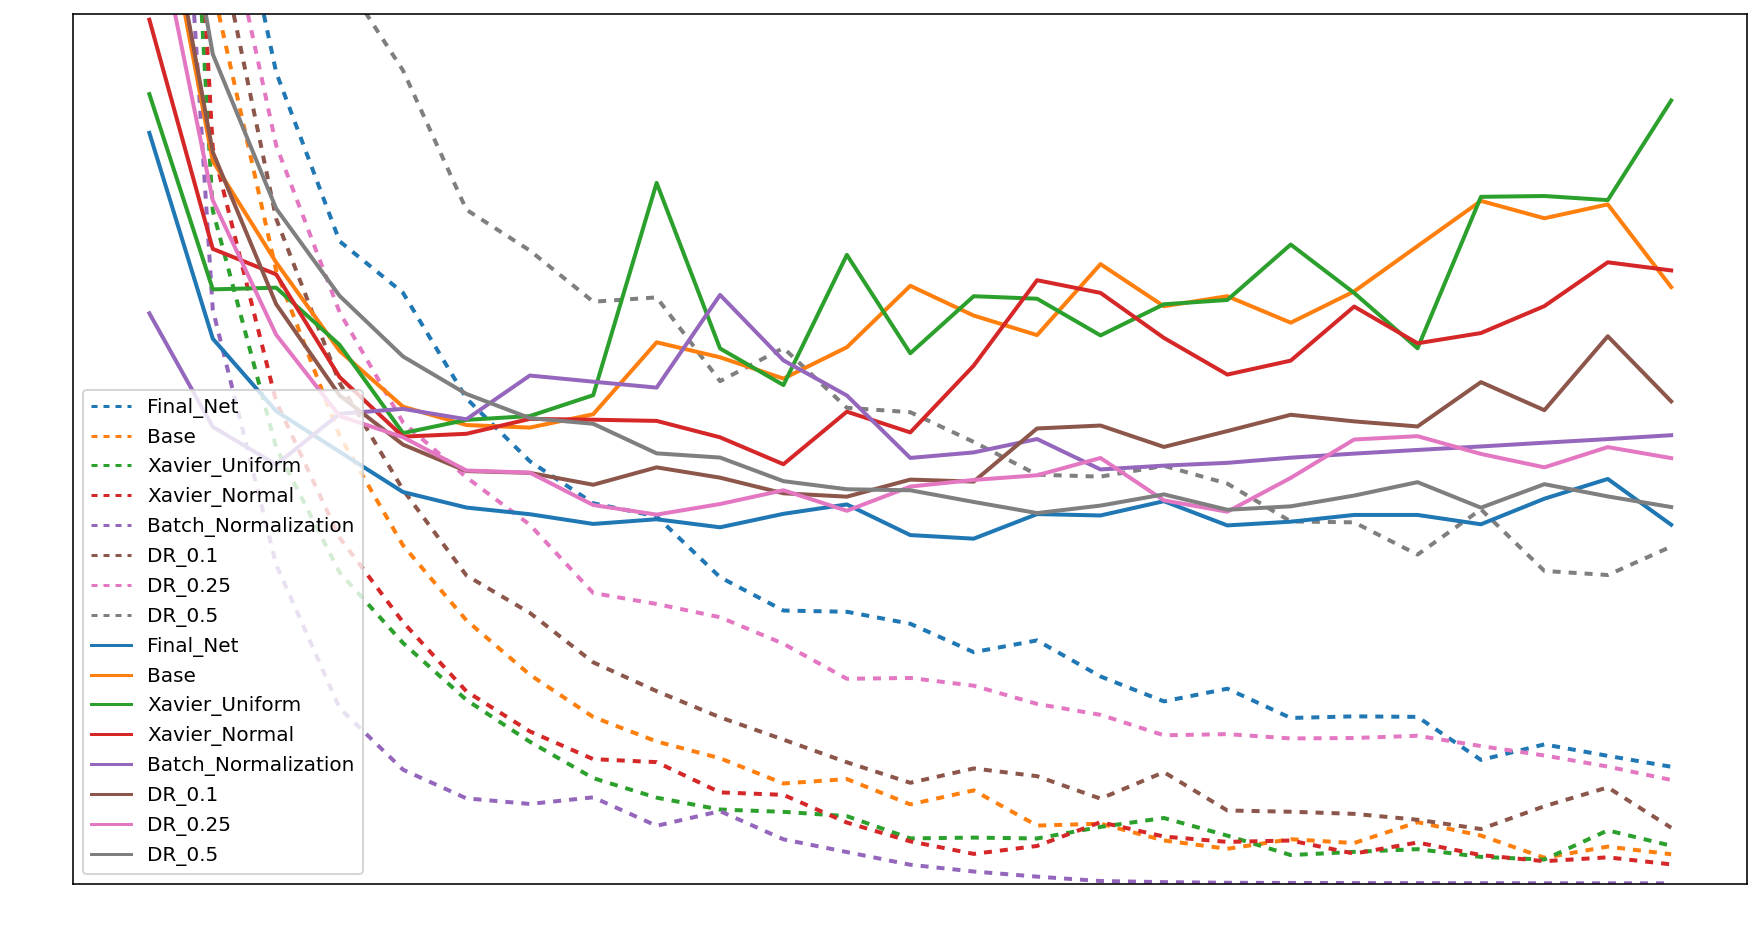

In [ ]:
FIN_NET_NAMES = final_th.columns
graph_history(TH_PATH, EH_PATH, FIN_NET_NAMES, ylim=(0,0.15), show_move_avg=False)

Legends
>Training Loss: Dashed Lines<br>
>Valiation Loss: Solid Lines<br>

<font color='skyblue'>`Final_Net` </font> (**Batch Normalization, Xavier Uniform Initialization, 25% Dropout**) shows the fastest **validation loss** decrease and shows less **overfitting** than the other nets.

### Prediction Visualization

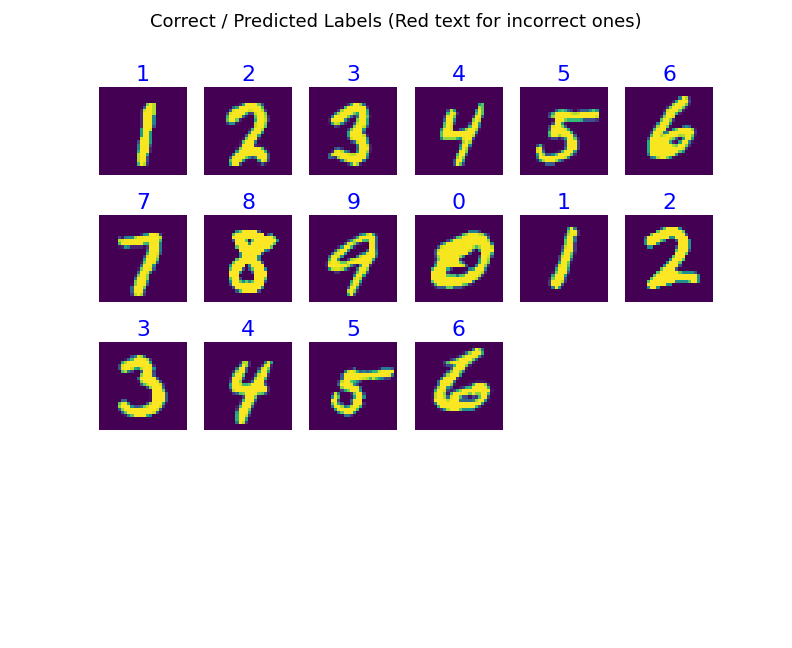

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread(RESULT_IMG_PATH, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

We can see that the predictions are correct.